In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

In [2]:
import cv2
from PIL import Image

In [3]:
import sys
sys.path.append("C:/git/computer-vision-control/")

# Read images

In [4]:
from glob import glob

In [9]:
hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/hand/*.png")
not_hand_files = glob("C:/git/computer-vision-control/images/hand_detection_augmented/not_hand/*.png")

In [10]:
len(hand_files)

3244

In [11]:
len(not_hand_files)

3244

# Camera Image

## Preprocessing

In [51]:
from vision_control.camera import *

In [52]:
img = CameraImage(file_path=hand_files[50])

In [53]:
img.preprocess()

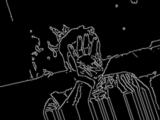

In [54]:
img

## Building the dataset

In [16]:
hand_img = [CameraImage(file_path = file_path,tag = 1,check = True) for file_path in tqdm(hand_files,desc = "Loading hand images")]
not_hand_img = [CameraImage(file_path = file_path,tag = 0,check = True) for file_path in tqdm(not_hand_files,desc = "Loading not hand images")]
all_img = hand_img + not_hand_img
all_img = [img for img in all_img if img.ok]

Loading not hand images: 100%|████████████| 3244/3244 [00:05<00:00, 629.17it/s]


In [55]:
images = CameraImages(camera_images=all_img)

In [56]:
images.preprocess()

Preprocessing images: 100%|██████████████| 6488/6488 [00:04<00:00, 1402.41it/s]


In [57]:
X = images.build_X()

100%|██████████████████████████████████████| 6488/6488 [03:38<00:00, 16.13it/s]


In [58]:
X.shape

(6488, 19200)

In [59]:
y = images.build_y()

In [60]:
y.shape

(6488, 1)

# Train a simple model

In [25]:
# Keras
from keras.models import Sequential
from keras.optimizers import SGD,RMSprop, Adam
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.models import model_from_json

Using TensorFlow backend.


## Creating the MLP

In [93]:
model = Sequential()
model.add(Dense(512,input_dim = X.shape[1],activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(512,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.75))
model.add(Dense(1,activation = "sigmoid"))
optimizer = Adam(lr=0.02)
model.compile(optimizer="adam",loss='binary_crossentropy',metrics=['accuracy'])

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [94]:
model.fit(X_train,y_train,epochs=50,verbose = 2,batch_size=32,shuffle=True,validation_data=(X_test,y_test))

Train on 4866 samples, validate on 1622 samples
Epoch 1/50
49s - loss: 1.0402 - acc: 0.5023 - val_loss: 0.6877 - val_acc: 0.5308
Epoch 2/50
50s - loss: 0.6977 - acc: 0.5158 - val_loss: 0.6821 - val_acc: 0.6708
Epoch 3/50
46s - loss: 0.6930 - acc: 0.5612 - val_loss: 0.6718 - val_acc: 0.5888
Epoch 4/50
50s - loss: 0.6808 - acc: 0.5849 - val_loss: 0.6529 - val_acc: 0.6874
Epoch 5/50
50s - loss: 0.6570 - acc: 0.6118 - val_loss: 0.6168 - val_acc: 0.6880
Epoch 6/50


KeyboardInterrupt: 

## Live test

In [47]:
test = CameraImage(capture = True)

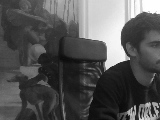

In [48]:
test.preprocess()
test

In [49]:
test.predict(model)

0.76100457

## Conclusion : 
The model fit very well on the train and dev set, but does not generalize to pictures in a production setting

## Saving the model

In [88]:
model.save("C:/git/computer-vision-control/models/model_mlp.h5")

In [89]:
with open("C:/git/computer-vision-control/models/model_mlp.json", "w") as json_file:
    json_file.write(model.to_json())

## Test reloading the model

In [2]:
%%time
from keras.models import model_from_json

Wall time: 0 ns


In [10]:
model = model_from_json(open("C:/git/computer-vision-control/models/model_mlp.json","r").read())
model.load_weights("C:/git/computer-vision-control/models/model_mlp.h5")

# Train a more complex model : CNN

## Building a dataset not flattened

In [23]:
X = images.build_X(flatten=False)
X.shape

(735, 240, 320, 1)

## Creating the model

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',input_shape=(240,320,1)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

optimizer = Adam(lr=0.01)
model.compile(optimizer="adam", loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
model.fit(X,y,validation_split=0.3,epochs=1,verbose = 1)

Train on 440 samples, validate on 189 samples
Epoch 1/1
440/440 [==============================] - ETA: 297s - loss: 2.6747 - acc: 0.562 - ETA: 234s - loss: 3.3301 - acc: 0.656 - ETA: 202s - loss: 4.2129 - acc: 0.645 - ETA: 178s - loss: 4.5297 - acc: 0.648 - ETA: 156s - loss: 4.9191 - acc: 0.637 - ETA: 137s - loss: 4.6805 - acc: 0.661 - ETA: 117s - loss: 4.7235 - acc: 0.665 - ETA: 98s - loss: 4.4445 - acc: 0.687 - ETA: 80s - loss: 4.6703 - acc: 0.67 - ETA: 62s - loss: 4.5022 - acc: 0.69 - ETA: 45s - loss: 4.2287 - acc: 0.71 - ETA: 28s - loss: 4.2085 - acc: 0.71 - ETA: 12s - loss: 4.3063 - acc: 0.70 - 251s - loss: 4.1801 - acc: 0.7182 - val_loss: 15.9424 - val_acc: 0.0000e+00


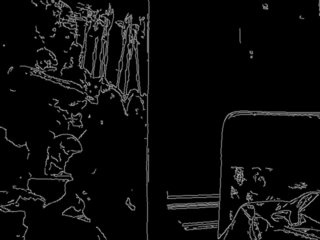

In [31]:
test = CameraImage(capture = True)
test.preprocess()
test

In [32]:
test.predict(model,flatten = False)

0.99779582

# Image Data Generator fit

https://keras.io/preprocessing/image/<br>
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

## Image Augmentation

In [20]:
from keras.preprocessing.image import ImageDataGenerator

In [24]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
#         rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)

In [38]:
hand_generator = train_datagen.flow(X[:367],y[:367],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/hand/')  # since we use binary_crossentropy loss, we need binary labels

not_hand_generator = train_datagen.flow(X[367:],y[367:],
        batch_size=batch_size,
        save_to_dir = 'c:/git/test/not_hand/')  # since we use binary_crossentropy loss, we need binary labels

In [40]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 

In [41]:
for e in range(10):
    print('Epoch', e)
    for x_batch, y_batch in not_hand_generator:
        pass

Epoch 0


KeyboardInterrupt: 